In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats
from mpmath import quad, npdf
import mpmath as mp
import matplotlib.cm as cm
from numpy import fft
from scipy.interpolate import interp1d
mp.dps = 10

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [11]:
def gaussian_mean(M, r, a=77.4, b=0.87, c=-0.23, fsusy=1):
    """Return mean of conditional luminosity distribution.
    
    Inputs:
        - M: mass of subhalo [solar masses]
        - r: distance from galactic center [kpc]
        - a: coefficient for first term [default=77.4]
        - b: coefficient for second term [default=0.97]
        - c: coefficient for third term [default=-0.23]
        - fsusy: value of fsusy [default=1e-28 [cm**3 s**-1 GeV**-2]]
        
    Returns:
        - mean of the gaussian distribution
    """
    return a + b * np.log(M / 1e5) + c * np.log(r / 50) #+ np.log(fsusy)


def gaussian_sd(M, r, a=0.74, b=-0.003, c=0.011):
    """Return the sd of the conditional luminosity function.
    
    Inputs:
        - M: mass of subhalo [solar masses]
        - r: distance from galactic center [kpc]
        - a: coefficient for first term [default=0.74]
        - b: coefficient for second term [default=-0.003]
        - c: coefficient for third term [default=-0.011]
    
    Returns:
        - sd of gaussian
    """
    return a + b * np.log(M / 1e5) + c * np.log(r / 50)


def conditional_luminosity_function(lnL, M, r, mean_params={}, sd_params={}):
    """Gives the value of the conditional luminosity function.
    
    Inputs:
        - lnL: natural log of lumionsity of the subhalo
        - M: mass of the subhalo [solar masses]
        - r: galactocentric radius of the subhalo [kpc]
        - mean_params: coefficients for parameter dependence for the distribution mean
        - sd_params: coefficients for parameter dependence for the sd of the distribution
        
    Returns:
        - value of the clf
    """
    if len(mean_params) > 0:
        mean = gaussian_mean(M, r, **mean_params)
    else:
        mean = gaussian_mean(M, r)

    if len(sd_params) > 0:
        sigma = gaussian_sd(M, r, **sd_params)
    else:
        sigma = gaussian_sd(M, r)
    
    return stats.norm.pdf(lnL, mean, sigma)


def mass_distribution(M, r, A=1.2e4, beta=1.9, rs=21):
    """Return the mass distribution value.
    
    Inputs:
        - M: mass of the subhalo [solar masses]
        - r: galactocentric radius of the subhalo [kpc]
        - A: amplitude [default=1.2e4 [solar mass**-1 kpc**-3]]
        - beta: strength of dependence on mass [default value=1.9]
        - rs: scale radius of Milky Way [default value=21 [kpc]]
        
    Returns:
        - value of mass distribution
    """
    r_tilde = r / rs
    
    return A * M**(-beta) / (r_tilde * (1 + r_tilde)**2)


def p1(F, psi, num=100, R_G=220, M_min=0.01, M_max=1e10, d_solar=8.5, mean_params={}, sd_params={}):
    """Return the unnormalized value of the probability distribution of one subhalo.
    
    Inputs:
        - F: flux of subhalo [photons/beam/year]
        - psi: angle from galactic center [degrees]
        - R_G: extent of dm halo [default value=220 [kpc]]
        - M_min: lower limit on mass integral [default=0.01 [solar masses]]
        - M_max: upper limit on mass integral [default=1e10 [solar masses]]
        - d_solar: galactocentric distance of sun [default=8.5 [kpc]]
        - mean_params: coefficients for parameter dependence for the distribution mean
        - sd_params: coefficients for parameter dependence for the sd of the distribution
        
    Returns:
        - value of probability of one subhalo for a given flux and angle
    """
    # Get upper bound for l integral
    psi_rad = np.deg2rad(psi)
    l_max = d_solar * (np.cos(psi_rad) + np.sqrt(-(np.sin(psi_rad)**2) + (R_G/d_solar)**2))
    
    # Convert years to seconds
    seconds_in_a_year = 3.154e7
    
    # Convert cm to kpc
    cm_in_a_kpc = 3.086e21
    
    def integrand_2d(M, l):
        # Luminosity
        Lsh = 4 * np.pi * l**2 * F / seconds_in_a_year / 2000 * cm_in_a_kpc**2
        
        # radius from GC
        r = np.sqrt(l**2 + d_solar**2 - 2*l*d_solar*np.cos(psi_rad))
        
        return l**4 * mass_distribution(M, r) / Lsh * conditional_luminosity_function(np.log(Lsh), M, r, mean_params=mean_params, sd_params=sd_params)
    
    lvals = np.linspace(1e-10, l_max, num=num)
    mvals = np.logspace(np.log10(M_min), np.log10(M_max), num=num)
    int_exp2d = integrate.simps(integrate.simps(integrand_2d(mvals[:,np.newaxis,np.newaxis],lvals[:,np.newaxis]), mvals, axis=0), lvals, axis=0)
    
    return int_exp2d


def mu(psi, R_G=220, M_min=0.01, M_max=1e10, d_solar=8.5, omega_pixel=0, num=100):
    """Compute mean value of subhalos in a pixel."""
    # Solid angle of pixel in sr
    if omega_pixel == 0:
        omega_pixel = 1 * (np.pi / 180)**2
    
    # Get upper bound for l integral
    psi_rad = np.deg2rad(psi)
    l_max = d_solar * (np.cos(psi_rad) + np.sqrt(-(np.sin(psi_rad)**2) + (R_G/d_solar)**2))
    
    def integrand_2d(M, l):
        # radius from GC
        r = np.sqrt(l**2 + d_solar**2 - 2*l*d_solar*np.cos(psi_rad))
        
        return l**2 * mass_distribution(M, r)

    lvals = np.linspace(1e-10, l_max, num=num)
    mvals = np.logspace(np.log10(M_min), np.log10(M_max), num=num)
    # perform the 2d integration by first integrating of mass than luminosity
    int_exp2d = integrate.simps(integrate.simps(integrand_2d(mvals[:, np.newaxis, np.newaxis],lvals[:, np.newaxis]), mvals, axis=0), lvals, axis=0)
    
    return omega_pixel * int_exp2d
    
    
# def integral_2d(func, y, x, num=100):
#     """Return discrete 2d integral of the function over the arrays x & y."""
    

def psh(psi, F_min=1e-20, F_max=1, num_points=2**7):
    """Return the function P_sh(F) for a given psi.
    
    Inputs:
        - psi: angle from galactic center [degrees]
        - F_min: minimum flux for FFT
        - F_max: maximum flux for FFT
        - num_bins: number of points to perform FFT (power of 2 for speed)
        
    Returns:
        - function of probability distribution psh at psi
    """
    F = np.logspace(np.log10(F_min), np.log10(F_max), num=num_points)
    p1_vals = (p1_unnorm := p1(F, psi))/integrate.simps(p1_unnorm, F)
    
    func = fft.ifft(np.exp(mu(psi) * (fft.fft(p1_vals) - 1)))
    
    psh_func = interp1d(F, func)
    return psh_func
    

In [12]:
flux = 1e-6
flux * p1(flux, 40, M_max=1e10)


array([4.91096399e-26])

slope near end for n=-1: -3.0190814488418236
slope near end for n=0: -0.044459869679010285
slope near end for n=2: -0.0018229828105700125
slope near end for n=4: -0.00048569968995192716


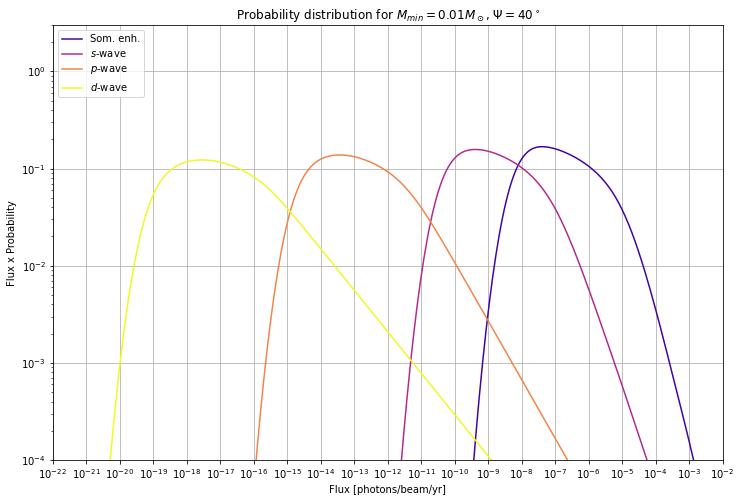

In [13]:
plt.close()

fig, ax = plt.subplots(figsize=(12, 8))
n_list = [-1, 0, 2, 4]
n_labels = {-1:"Som. enh.", 0: r"$s$-wave", 2:r"$p$-wave", 4:r"$d$-wave"}
colors = iter(cm.plasma(np.linspace(0.1, 1, num=len(n_list))))

for n in n_list:
    mean_params = {'a':77.4, 'b':0.87+0.31*n, 'c':-0.23-0.04*n}
    logmin = -22
    logmax = -1
    fluxes = np.logspace(logmin, logmax, num=(logmax-logmin)*20)
    probs = p1(fluxes, 40, mean_params=mean_params, num=200)
    # probs = [p1(flux, 40) for flux in fluxes]
    normalization = np.trapz(probs, fluxes)
    func = fluxes*probs/normalization
#     print(normalization)

    ax.plot(fluxes, func, label=n_labels[n], color=next(colors))
    print(f'slope near end for n={n}: {(func[-60]-func[-40])/(fluxes[-60]-fluxes[-40])}')

ax.set_xscale('log')
ax.set_xlabel('Flux [photons/beam/yr]')
ax.set_ylabel('Flux x Probability')
ax.set_yscale('log')
ax.set_ylim(bottom=1e-4, top=3)
ax.set_xlim(left=1e-22, right=1e-2)

ax.set_title(r"Probability distribution for $M_{min}=0.01 M_\odot$, $\Psi=40^\circ$")

# fluxes = np.logspace(-15, -3, num=25)
# # probs = p1(fluxes, 40, M_min=1e-6)
# probs = [p1(flux, 40, M_min=1e-6) for flux in fluxes]
# normalization = np.trapz(probs, fluxes)
# ax.plot(fluxes, fluxes*probs/normalization, label=r"$M_{min}=10^{-6} M_\odot$", color="xkcd:robin's egg blue")

ax.legend(loc='upper left')
ax.grid()
ax.set_xticks([1e-22 * 10**i for i in range(21)]);

In [14]:
fig.savefig('eq4_w_vel_dep.png')

<ipython-input-15-02d0117cf17c>:14: RuntimeWarning: divide by zero encountered in log10
  func = np.log10(probs/normalization)
<ipython-input-15-02d0117cf17c>:18: RuntimeWarning: invalid value encountered in subtract
  ax.plot(fluxes[:-1], (func[:-1]-func[1:])/(np.log10(fluxes[:-1])-np.log10(fluxes[1:])), label=n_labels[n], color=col)


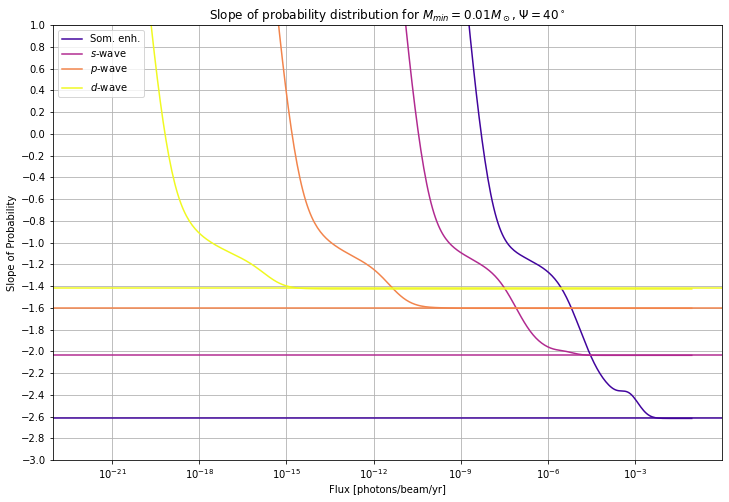

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
n_list = [-1, 0, 2, 4]
n_labels = {-1:"Som. enh.", 0: r"$s$-wave", 2:r"$p$-wave", 4:r"$d$-wave"}
colors = iter(cm.plasma(np.linspace(0.1, 1, num=len(n_list))))

for n in n_list:
    mean_params = {'a':77.4, 'b':0.87+0.31*n, 'c':-0.23-0.04*n}
    logmin = -22
    logmax = -1
    fluxes = np.logspace(logmin, logmax, num=(logmax-logmin)*20)
    probs = p1(fluxes, 40, mean_params=mean_params, num=200)
    # probs = [p1(flux, 40) for flux in fluxes]
    normalization = np.trapz(probs, fluxes)
    func = np.log10(probs/normalization)
#     print(normalization)
    col = next(colors)

    ax.plot(fluxes[:-1], (func[:-1]-func[1:])/(np.log10(fluxes[:-1])-np.log10(fluxes[1:])), label=n_labels[n], color=col)
    ax.axhline(-1.03/(1+.36*n)-1, color=col)
#     print(f'slope near end for n={n}: {(func[-60]-func[-40])/(fluxes[-60]-fluxes[-40])}')
# 
ax.set_xscale('log')
ax.set_xlabel('Flux [photons/beam/yr]')
ax.set_ylabel('Slope of Probability')
# ax.set_yscale('log')
ax.set_ylim(bottom=-3, top=1)
# ax.set_xlim(left=1e-22, right=1e-2)

ax.set_title(r"Slope of probability distribution for $M_{min}=0.01 M_\odot$, $\Psi=40^\circ$")

# fluxes = np.logspace(-15, -3, num=25)
# # probs = p1(fluxes, 40, M_min=1e-6)
# probs = [p1(flux, 40, M_min=1e-6) for flux in fluxes]
# normalization = np.trapz(probs, fluxes)
# ax.plot(fluxes, fluxes*probs/normalization, label=r"$M_{min}=10^{-6} M_\odot$", color="xkcd:robin's egg blue")

ax.legend(loc='upper left')
ax.set_yticks(np.linspace(-3, 1, num=21))
ax.grid(which='both')

In [16]:
import astropy.table as table
from astropy.io import fits
fermi_bkgs = table.Table.read('/Users/runburg/Downloads/gll_iem_v07.fits')
catalog = fits.open("/Users/runburg/Downloads/gll_iem_v07.fits", memmap=True)

ModuleNotFoundError: No module named 'astropy'

In [17]:
catalog.info

NameError: name 'catalog' is not defined

In [18]:
[mu(psi) for psi in np.linspace(30, 90, num=7)]

[array([5282096.94906369]),
 array([4857926.514758]),
 array([4487034.48826372]),
 array([4158807.80234018]),
 array([3868063.09160805]),
 array([3611546.08313174]),
 array([3386769.29945527])]

In [19]:
catalog[0].header

NameError: name 'catalog' is not defined

In [20]:
table.Table.read(catalog[1])

NameError: name 'table' is not defined

In [21]:
psi = 40
num = 5000
F = np.logspace(-15, 0, num=num)
mu(psi) * integrate.simps(F*p1(F, psi), F), integrate.simps(F*psh(psi)(F), F)

<ipython-input-11-1f341301c333>:163: RuntimeWarning: overflow encountered in exp
  func = fft.ifft(np.exp(mu(psi) * (fft.fft(p1_vals) - 1)))


(array([3.51652745e-24]), (nan+nanj))

Text(0, 0.5, '$\\mu$($\\Psi$)')

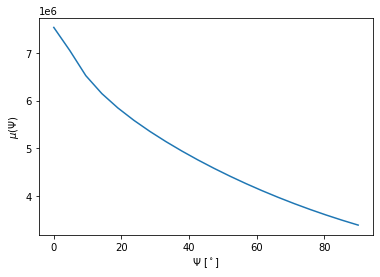

In [22]:
fig, ax = plt.subplots()
psis = np.linspace(0, 90, num=20)
ax.plot(psis, [mu(pssi) for pssi in psis])
ax.set_xlabel(r'$\Psi$ [$^\circ$]')
ax.set_ylabel(r'$\mu$($\Psi$)')

In [23]:
np.exp(1e2)

2.6881171418161356e+43

In [24]:
mu(40)[0], mu(60)[0], mu(80)[0]

(4857926.514757997, 4158807.802340182, 3611546.08313174)

In [25]:
R_G = 220 #Kpc
d_sun = 8.5 #kpc
psi = 40
M_min = 1.0e-2 #Msun
M_max = 1.0e10 #Msun
fwimp = 1.0
nside_map = 2048
Omega_pixel = 4.*np.pi/(12*nside_map**2.) #sr
area_fermi = 2000.0 #cm^2
mu(40, R_G=R_G, M_min=M_min, M_max=M_max, d_solar=d_sun, omega_pixel=Omega_pixel)

array([3981.66684838])

In [395]:
N = 30000
psi = 40
fluxes = np.logspace(-50, 10, num=N)

p1_vals = p1(fluxes, psi, num=100)
p1_vals /= integrate.simps(p1_vals, fluxes)

# k = np.flip(1/fluxes)
# k = 1/fluxes

In [396]:
(mu(psi) * integrate.simps(fluxes * p1_vals, fluxes))[0]

0.5368546776955918

/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


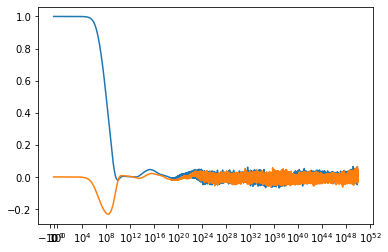

In [397]:
# k = np.concatenate((-1/fluxes, np.flip(1/fluxes)))
k = np.flip(1/fluxes)
func = p1_vals * np.exp(-2j * np.pi * fluxes * k[:, np.newaxis])
# func = p1_vals * np.cos(-2 * np.pi * fluxes * k[:, np.newaxis])
ft_p1 = integrate.simps(func, fluxes, axis=1)
fig, ax = plt.subplots()
ax.plot(k, ft_p1)
ax.plot(k, ft_p1.imag)
ax.set_xscale('symlog')

In [398]:
mean = mu(psi)
sd = np.sqrt(mu(psi))
print(mean, '+/-', sd)
# gauss = stats.norm.pdf(, mean, sd)
eval_pts = np.linspace(mean - 5 * sd, mean + 5 * sd, num=50)
# # # print(np.exp(2j * np.pi * fluxes[:, np.newaxis] * k).shape, (ft_p1**eval_pts).shape)
# # print((np.exp(2j * np.pi * fluxes[:, np.newaxis, np.newaxis] * k)* ft_p1**eval_pts).shape)
# fluxes *= 1e4
ks = np.concatenate((-np.flip(k), k))
ft_p1s = np.concatenate((np.conj(np.flip(ft_p1)), ft_p1))
fluxess = np.logspace(-1, 3, num=300)
func = ft_p1s**eval_pts * np.exp(2j * np.pi * fluxess[:, np.newaxis, np.newaxis] * ks)

ift_func = integrate.simps(func, ks, axis=2)
# print(ift_func)
# print((ift_func*eval_pts.T).shape)
pf = integrate.simps(ift_func * stats.norm.pdf(eval_pts, mean, sd).T, eval_pts.T, axis=1)
# pf

[4857926.514758] +/- [2204.07044233]


/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


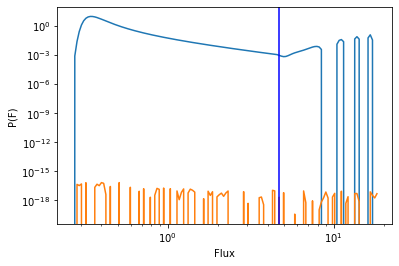

In [402]:
fig, ax = plt.subplots()
start = (N*710)//1000
start = 32
end = -130

# end = (N*800)//1000
ax.plot(fluxess[start:end], pf[start:end])
ax.plot(fluxess[start:end], pf[start:end].imag)
limi = -175
ax.axvline(fluxess[limi], c='b')
# print(pf.imag)
# print(pf[:100])
ax.set_xscale('log')
# fluxes
ax.set_xscale('log')
ax.set_xlabel('Flux')
ax.set_ylabel('P(F)')
ax.set_yscale('log')
# ax.set_xlim(right=2)
# print(fluxes[800:900])

In [403]:
print(f'\mu \int F P1: {(mu(psi) * integrate.simps(fluxes * p1_vals, fluxes))[0]}')
print(f' \int F Psh: {integrate.simps(pf[start:limi].real * fluxess[start:limi], fluxess[start:limi])}')

\mu \int F P1: 0.5368546776955918
 \int F Psh: 0.4417581019120139


0.22395792354833532


0.5222704904370657

In [325]:
# N=30000, bounds = (-50, 10)
0.4292
0.5223


# N=30000, bounds=(-40, 10)
0.43555429045193855
Out[344]:
0.5222704904370656

0.41764269656926734
Out[157]:
0.5495383367409762

0.4056755684464056
Out[100]:
0.5462375569916547

SyntaxError: invalid syntax (<ipython-input-325-574b6f73b8bd>, line 2)

In [ ]:
fig, axs = plt.subplots()
i = 0
axs.plot(fluxes[i:], fluxes[i:] * p1_vals[i:] * mu(psi))
axs.set_xscale('log')
axs.set_yscale('log')

In [ ]:
fig, ax = plt.subplots()
ax.plot(fluxes, p1_vals)
ax.set_xscale('log')
# fluxes
ax.set_xscale('log')
ax.set_xlabel('Flux')
ax.set_ylabel('P(F)')
ax.set_yscale('log')

In [ ]:
funcinv = ft_p1 * np.exp(2j * np.pi * fluxes[:, np.newaxis] * k)
ft_p1inv = integrate.simps(funcinv, k, axis=1)
len(ft_p1), len(fluxes)
ft_p1inv

In [ ]:
fig, ax = plt.subplots()
ax.plot(fluxes, ft_p1inv)
ax.plot(fluxes, p1_vals)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(left=1e-16, right=1)

In [ ]:
psi = 40
poisson = lambda F: stats.poisson.pmf(F, mu(psi))
epsilon = 1e-10
pf = poisson(0) + poisson(1) * p1_vals

In [ ]:
print('max k', mu(psi))
maxk = int(mu(psi) * 10)
for i in range(2, maxk):
    func = ft_p1**i * np.exp(2j * np.pi * fluxes[:, np.newaxis] * k)
    ift_func = integrate.simps(func, k, axis=1)
#     print(ift_func.real)
    if i % 10000 == 0:
        print('completed', i, 'of', maxk)
    pf += poisson(i)*ift_func.real

mu*\int dF F*P_1(F) vs. \int dF F*P_sh(F)

In [ ]:
# fft.fft(p1_lin)

# fft.ifft(np.exp((fft.fft(p1_lin, norm='ortho') - 1)))[::num//10]

# norm_psh = integrate.simps(p_sh, fluxes)

# fig, ax = plt.subplots()
# ax.plot(fluxes, p_sh * fluxes / norm_psh, color='xkcd:bubblegum pink')
# ax.set_xscale('log')
# ax.set_xlabel('Flux')
# ax.set_ylabel('Flux x P_sh')

# import nfft

# psi = 40
# N = 10000
# fluxes = np.logspace(-20, 0, num=N//100)
# p1_vals = p1(fluxes, psi)
# # print(p1_vals[:])
# normalization = integrate.simps(p1_vals, fluxes) 
# p1_vals /= normalization

# f_k_direct = nfft.ndft_adjoint(fluxes, p1_vals, N)
# # # print(f_k_direct)
# # f_k_direct/1e8
# f_k_direct

# # nfft.ndft(fluxes, nfft.ndft_adjoint(fluxes, p1_vals, N))[::100], p1_vals[::100]

# import pyfftlog

# # angle in the sky
# psi = 40

# # number of points (max 4096)
# N = 2**10

# # bounds of interval log
# logfmin = -20
# logfmax = 1

# # k_c f_c (c is center point of array)
# kf = 1

# # order of bessel function
# mvu = 1/2

# # bias exponent
# q = 0

# # forward direction
# tdir = 1

# # Try to deal with any non-smoothness
# kropt = 1
